# Basics

In [1]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.10.1
Keras Version: 2.10.0

Python 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
GPU is available


In [2]:
import logging
import os
import sys
import threading
import time
from datetime import datetime, timedelta
from dateutil import tz
from pathlib import Path
import numpy as np
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
from dotenv import load_dotenv
import pickle
import itertools

from utils import pred_color, save_fig
import pandas as pd
from pandas.plotting import lag_plot
import statsmodels.api as sm
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

#import seaborn as sns


import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.colors import ListedColormap
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = "1" # Added the environment variable.

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

Tensor Flow Version: 2.10.1
Keras Version: 2.10.0

Python 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
GPU is available


In [3]:
dotenv_path = Path('./config/.env')
load_dotenv(dotenv_path=dotenv_path)
APCA_API_KEY_ID = os.environ.get("APCA_API_KEY_ID")
APCA_API_SECRET_KEY = os.environ.get("APCA_API_SECRET_KEY")
NY = 'America/New_York'
CHI = 'America/Chicago'
UTC = 'UTC'
BASE_URL = "https://paper-api.alpaca.markets"

In [4]:
tickers = ['NVDA']
api = tradeapi.REST(key_id=APCA_API_KEY_ID, secret_key=APCA_API_SECRET_KEY,
                    base_url=BASE_URL, api_version='v2')

In [5]:
start_date = pd.Timestamp('2023-09-01T00:00', tz=UTC).isoformat()
end_date = pd.Timestamp('2023-10-16T00:00', tz=UTC).isoformat()
#end_date = (pd.Timestamp.now(tz=UTC) - timedelta(minutes=16)).isoformat()
df1 = pd.DataFrame()
for count1, ticker in enumerate(tickers):
        print(ticker)
        temp_df = api.get_bars(ticker, TimeFrame.Minute, start_date, end_date, adjustment='raw').df
        temp_df['Ticker'] = ticker
        df1 = pd.concat([df1, temp_df])

NVDA


In [6]:
path_file = './data'
ticker_file = 'nvda_data.pkl'
pickle_out = open(path_file + '/' + ticker_file, "wb")
pickle.dump(df1, pickle_out)
pickle_out.close()

In [7]:
df = pd.read_pickle('./data/nvda_data.pkl')
df.head(5)

,close,high,low,trade_count,open,volume,vwap,Ticker
timestamp,,,,,,,,
2023-09-01 08:00:00+00:00,492.47,493.0,492.47,77,493.00,2503,492.773416,NVDA
2023-09-01 08:01:00+00:00,492.60,492.6,492.47,33,492.47,1323,492.662071,NVDA
2023-09-01 08:02:00+00:00,492.60,492.6,492.60,18,492.60,409,492.553423,NVDA
2023-09-01 08:03:00+00:00,492.60,492.6,492.60,19,492.60,521,492.473589,NVDA
2023-09-01 08:05:00+00:00,492.03,492.2,492.03,35,492.20,747,492.114779,NVDA


# RNN - stacked LSTM

## Single Attribute

In [8]:
df.head(5)

,close,high,low,trade_count,open,volume,vwap,Ticker
timestamp,,,,,,,,
2023-09-01 08:00:00+00:00,492.47,493.0,492.47,77,493.00,2503,492.773416,NVDA
2023-09-01 08:01:00+00:00,492.60,492.6,492.47,33,492.47,1323,492.662071,NVDA
2023-09-01 08:02:00+00:00,492.60,492.6,492.60,18,492.60,409,492.553423,NVDA
2023-09-01 08:03:00+00:00,492.60,492.6,492.60,19,492.60,521,492.473589,NVDA
2023-09-01 08:05:00+00:00,492.03,492.2,492.03,35,492.20,747,492.114779,NVDA


Text(0, 0.5, 'Prices ($)')

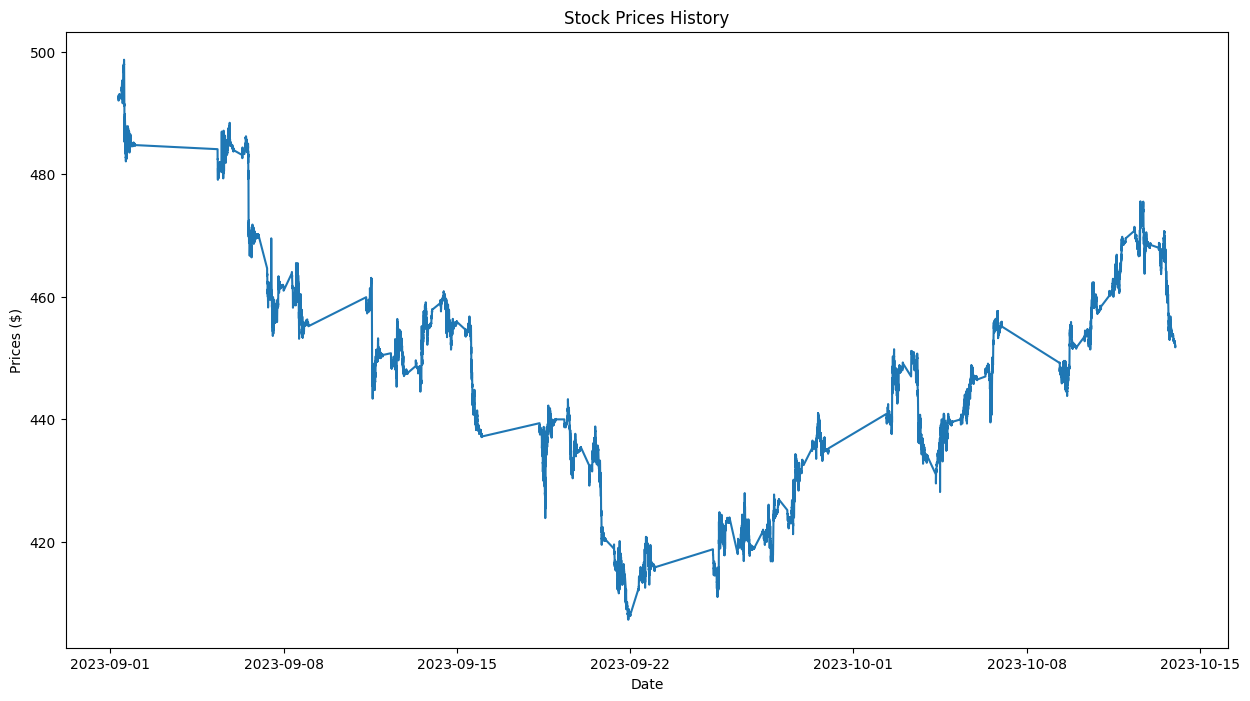

In [9]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [10]:
open_prices = df['close']
values = open_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))



scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

# dump Scaler for reuse
import joblib
joblib.dump(scaler, r'.\models\nvda_minmax_scaler.pkl')

x_train = []
y_train = []

for i in range(6, len(train_data)):
    x_train.append(train_data[i-6:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
test_data = scaled_data[training_data_len-6: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(6, len(test_data)):
    x_test.append(test_data[i-6:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [12]:
start_time = time.time()
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(64,  activation="relu", input_shape=(10,)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 127,729
Trainable params: 127,729
Non-trainable params: 0
_________________________________________________________________


In [13]:
file_path = r'.\models\nvda_lstm_model.h5'
model.compile(optimizer='adam', loss='mean_squared_error')
#model.fit(x_train, y_train, batch_size= 1, epochs=1)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)
model.fit(x_train, y_train,  epochs=40, batch_size=64, callbacks=[es, mc])
end_time = time.time()

Epoch 1/40
285/292 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 1: loss improved from inf to 0.00441, saving model to .\models\nvda_lstm_model.h5
292/292 [==============================] - 7s 6ms/step - loss: 0.0044
Epoch 2/40
290/292 [============================>.] - ETA: 0s - loss: 5.5392e-05
Epoch 2: loss improved from 0.00441 to 0.00006, saving model to .\models\nvda_lstm_model.h5
292/292 [==============================] - 1s 5ms/step - loss: 5.5400e-05
Epoch 3/40
283/292 [============================>.] - ETA: 0s - loss: 5.5568e-05
Epoch 3: loss did not improve from 0.00006
292/292 [==============================] - 1s 5ms/step - loss: 5.5617e-05
Epoch 4/40
288/292 [============================>.] - ETA: 0s - loss: 5.5375e-05
Epoch 4: loss improved from 0.00006 to 0.00006, saving model to .\models\nvda_lstm_model.h5
292/292 [==============================] - 1s 5ms/step - loss: 5.5326e-05
Epoch 5/40
291/292 [============================>.] - ETA: 0s - loss: 5.8

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

146/146 [==============================] - 1s 2ms/step


In [15]:
rmse

# 2.3591238157518872
# 0.40202189924798
# 1.3736014185068552
#0.20572080651738656

0.14382918122338045

In [16]:
LSTM_time_taken = end_time - start_time
LSTM_MSE_error = mean_squared_error(y_test, predictions)
print('Testing Mean Squared Error is {}'.format(LSTM_MSE_error))
print(f"The time taken to run the model is {LSTM_time_taken} seconds.")

Testing Mean Squared Error is 0.323830738593752
The time taken to run the model is 20.382816553115845 seconds.


In [17]:
results_lstm = model.evaluate(x_test, y_test)
print("test loss, test acc:", np.round(results_lstm, 4))

146/146 [==============================] - 1s 2ms/step - loss: 210091.0469
test loss, test acc: 210091.0469


Saving figure LSTM


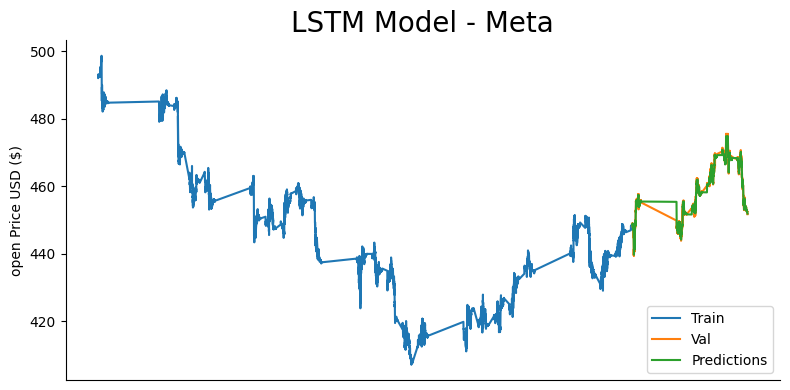

In [18]:
data = df.filter(['open'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
fig, ax = plt.subplots(figsize= (8,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
plt.plot(train)
plt.plot(validation[['open', 'Predictions']])
plt.title('LSTM Model - Meta',  fontsize=20)
plt.xticks([]) 
plt.ylabel('open Price USD ($)')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.grid(False)
save_fig('LSTM')
plt.show()

In [19]:
model.save(r'.\models\nvda_lstm_model.h5') 

In [20]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open(r".\models\nvda_lstm_model.json", "w") as json_file:
    json_file.write(model_json)
    
json_file.close()

In [21]:
# Save the model weights to an HDF5 file
model.save_weights(r".\models\nvda_lstm_model_weights.h5")

## Multiple Attributes

- open price
- Volume

In [22]:
df = pd.read_pickle('./data/nvda_data.pkl')
df = df.drop(['high', 'low', 'trade_count', 'close', 'vwap', 'Ticker'], axis=1)
df=df.reset_index(drop = True)

In [23]:
df

,open,volume
0,493.00,2503
1,492.47,1323
2,492.60,409
3,492.60,521
4,492.20,747
...,...,...
23334,452.00,5099
23335,451.90,5948
23336,451.84,3021
23337,451.85,4472


In [24]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
df_scaled = sc.fit_transform(df)

In [25]:
df_scaled.shape

(23339, 2)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_size=0.8

In [28]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [29]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(df_scaled, 
                                                             n_future=5, 
                                                             n_past=25, 
                                                             train_test_split_percentage=0.8,                                               
                                                             validation_split_percentage = 0)

In [30]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(18648, 25, 2)
(4662, 25, 2)
(18648, 1)
(4662, 1)


### Train Model

In [31]:
# ------------------LSTM-----------------------
model = keras.Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 16)            1216      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fit model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
204/204 [==============================] - 5s 12ms/step - loss: 0.0194 - root_mean_squared_error: 0.1392 - val_loss: 2.1987e-04 - val_root_mean_squared_error: 0.0148
Epoch 2/40
204/204 [==============================] - 2s 8ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 2.5618e-04 - val_root_mean_squared_error: 0.0160
Epoch 3/40
204/204 [==============================] - 2s 8ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 1.5969e-04 - val_root_mean_squared_error: 0.0126
Epoch 4/40
204/204 [==============================] - 2s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 5.0833e-04 - val_root_mean_squared_error: 0.0225
Epoch 5/40
204/204 [==============================] - 2s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 1.6306e-04 - val_root_mean_squared_error: 0.0128
Epoch 6/40
204/204 [==============================] - 2s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516 - va

In [33]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

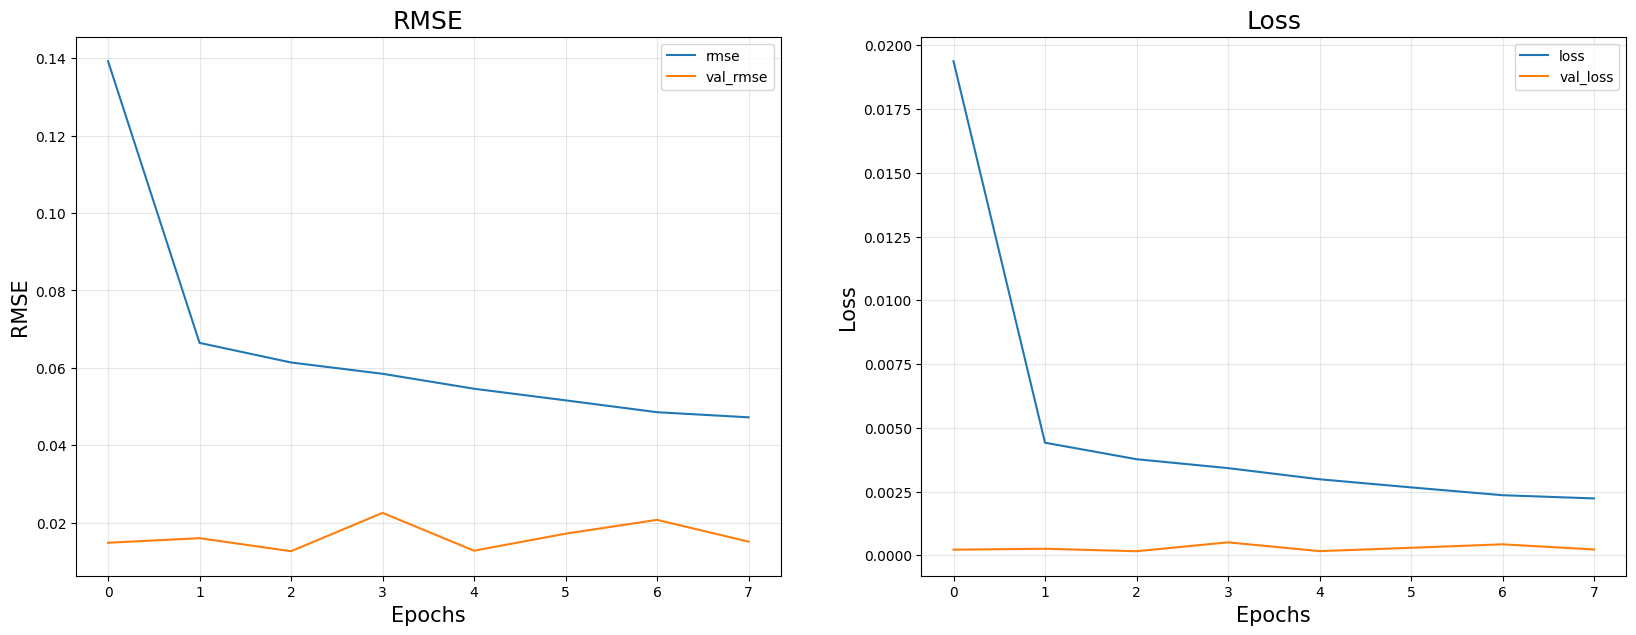

In [34]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [35]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

146/146 [==============================] - 1s 4ms/step - loss: 2.0389e-04 - root_mean_squared_error: 0.0143
test loss, test acc: [0.0002 0.0143]


### Hyperparameter Tuning

In [36]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            #regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

        file_path = r'.\models\best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=10, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [37]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00023, saving model to .\models\best_model.h5

Epoch 2: val_loss improved from 0.00023 to 0.00014, saving model to .\models\best_model.h5

Epoch 3: val_loss improved from 0.00014 to 0.00011, saving model to .\models\best_model.h5

Epoch 4: val_loss did not improve from 0.00011

Epoch 5: val_loss did not improve from 0.00011

Epoch 6: val_loss did not improve from 0.00011

Epoch 7: val_loss did not improve from 0.00011

Epoch 8: val_loss improved from 0.00011 to 0.00011, saving model to .\models\best_model.h5

Epoch 9: val_loss did not improve from 0.00011

Epoch 10: val_loss did not improve from 0.00011
0-th combination = (False, False, False, 1

### Best Model

In [38]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
4,False,False,False,32,16,0.2,"[0.0001986217830562964, 0.014093323610723019]","[8.695570431882516e-05, 0.009325004182755947]"
3,False,False,False,32,8,0.2,"[0.00013688330363947898, 0.01169971376657486]","[0.00011446286953287199, 0.010698731988668442]"
0,False,False,False,16,8,0.2,"[0.00020614215463865548, 0.014357651583850384]","[0.00013165779819246382, 0.011474222876131535]"
1,False,False,False,16,16,0.2,"[0.0001997998624574393, 0.014135058037936687]","[0.00018663493392523378, 0.013661439530551434]"
2,False,False,False,16,32,0.2,"[0.00018711245502345264, 0.013678905554115772]","[0.0002088599867420271, 0.014451988972723484]"
5,False,False,False,32,32,0.2,"[0.0002825748233590275, 0.016809960827231407]","[0.000280773761915043, 0.01675630547106266]"


### results

In [39]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 16
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0143

Results After Tunning:
 Test Set RMSE: 0.0093

35.0% Improvement


In [40]:
first_additional_layer,second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [41]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = r'.\models\best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.00020, saving model to .\models\best_model.h5

Epoch 2: val_loss improved from 0.00020 to 0.00016, saving model to .\models\best_model.h5

Epoch 3: val_loss improved from 0.00016 to 0.00013, saving model to .\models\best_model.h5

Epoch 4: val_loss did not improve from 0.00013

Epoch 5: val_loss improved from 0.00013 to 0.00011, saving model to .\models\best_model.h5

Epoch 6: val_loss improved from 0.00011 to 0.00010, saving model to .\models\best_model.h5

Epoch 7: val_loss did not improve from 0.00010

Epoch 8: val_loss did not improve from 0.00010

Epoch 9: val_loss improved from 0.00010 to 0.00010, saving model to .\models\best_model.h5

Epoch 10: val_loss did not improve from 0.00010

Epoch 11: val_loss did not improve from 0.00010

Epoch 12: val_loss did not improve from 0.00010

Epoch 13: val_loss did not improve from 0.00010

Epoch 14: val_loss improved from 0.00010 to 0.00009, saving model to .\models\best_model.h5

Epoch 15: val_loss

In [42]:
regressor.evaluate(X_test, y_test)

146/146 [==============================] - 1s 3ms/step - loss: 9.7004e-05


9.700426016934216e-05

146/146 [==============================] - 1s 3ms/step


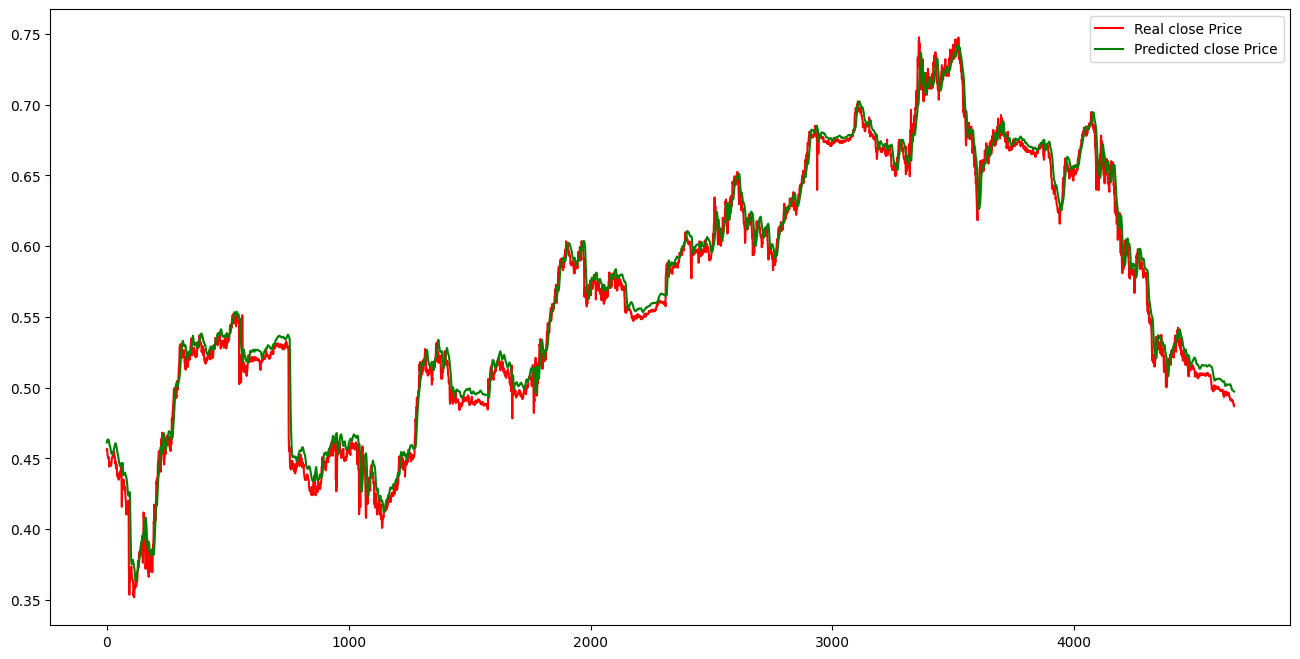

In [43]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real close Price')
plt.plot(y_pred, color='green', label = 'Predicted close Price')
plt.legend(loc='best')

In [44]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.004199227878161798

# Arima

## Correlation

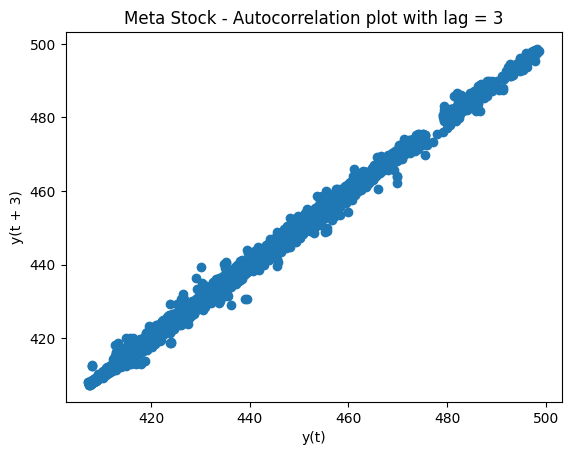

In [45]:
plt.figure()
lag_plot(df['open'], lag=3)
plt.title('Meta Stock - Autocorrelation plot with lag = 3')
plt.show()

## Model

In [46]:
start_time = time.time()
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
training_data = train_data['open'].values
test_data = test_data['open'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    #print(N_test_observations - time_point)
    model = sm.tsa.arima.ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
ARIMA_MSE_error = mean_squared_error(test_data, model_predictions)
end_time = time.time()
arima_time_taken = end_time - start_time
print('Testing Mean Squared Error is {}'.format(ARIMA_MSE_error))
print(f"The time taken to run the model is {arima_time_taken} seconds.")

Testing Mean Squared Error is 0.13193716048320708
The time taken to run the model is 3027.1613161563873 seconds.


Saving figure ARIMA


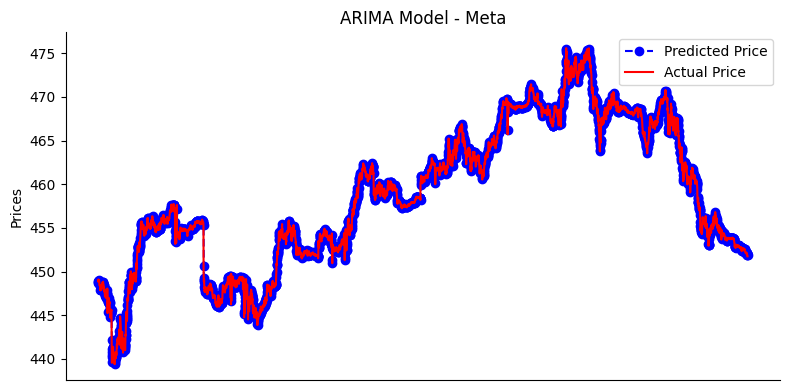

In [47]:
test_set_range = df[int(len(df)*0.8):].index
fig, ax = plt.subplots(figsize= (8,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
#plt.legend(['Predicted Price', 'Actual Price'], loc='lower right')
plt.title('ARIMA Model - Meta')
plt.xticks([])
plt.ylabel('Prices')
plt.legend()
save_fig('ARIMA')
plt.show()

# Results

In [48]:
print('Testing ARIMA Mean Squared Error is {}'.format(ARIMA_MSE_error))
print(f"The time taken to run the model is {arima_time_taken} seconds.")

Testing ARIMA Mean Squared Error is 0.13193716048320708
The time taken to run the model is 3027.1613161563873 seconds.


In [49]:
print('Testing Mean Squared Error is {}'.format(LSTM_MSE_error))
print(f"The time taken to run the model is {LSTM_time_taken} seconds.")

Testing Mean Squared Error is 0.323830738593752
The time taken to run the model is 20.382816553115845 seconds.
